In [76]:
import numpy as np
from scipy import misc
import glob
import imageio
from PIL import Image
import skimage
from keras.models import Model,Input
from keras.layers import *
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
import pickle

In [77]:
global imgs
imgs = np.array(glob.glob('DATA/*.jpg'))
height,width = imageio.imread(imgs[0]).shape[:2]
center_height = int((height - width) / 2)
print(height,width)


250 250


In [143]:
data = np.zeros((len(imgs),1))

with open('new_data.pkl', 'rb') as f:
    data_p = pickle.load(f)

data[:,0] = data_p['smily']
#data[:,1] = data_p['frowning']
#data[:,2] = data_p['chubby']

print(data)

[[-1.0914066 ]
 [-1.82603673]
 [ 0.76688574]
 ...
 [-0.72558441]
 [-0.76961268]
 [ 1.52931442]]


In [141]:
# hyper parameters
total_epoch = 256
batch_size = 64
img_dim = 64
z_dim = 512

In [80]:
def imread(f):
    x = Image.open(f)
    x = x.resize((img_dim, img_dim), Image.ANTIALIAS)
    x = np.asarray(x)
    x = x.astype(np.float32) / 255 * 2 - 1
    return x

In [81]:
def data_generator(bs=64):
    global imgs
    X = []
    Y = []
    
    while True:
        indices = np.arange(imgs.shape[0])
        np.random.shuffle(indices)
        imgs = imgs[indices]
        atts = data[indices]
        cnt = 0
        
        for f in imgs:
            
            X.append(imread(f))
            Y.append(atts[cnt])
            cnt+=1
            
            if len(X) == bs:
                cnt = 0
                X = np.array(X)
                Y = np.array(Y)
                yield [X,Y],None
                X = []
                Y = []

In [82]:
# Encoder
x_image = Input(shape=(img_dim, img_dim, 3))
x = x_image
x = Conv2D(int(z_dim/16), kernel_size=(5,5), strides=(2,2), padding='SAME')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(int(z_dim/8), kernel_size=(5,5), strides=(2,2), padding='SAME')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(int(z_dim/4), kernel_size=(5,5), strides=(2,2), padding='SAME')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(int(z_dim/2), kernel_size=(5,5), strides=(2,2), padding='SAME')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(z_dim, kernel_size=(5,5), strides=(2,2), padding='SAME')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = GlobalAveragePooling2D()(x)

encoder = Model(x_image,x)
encoder.summary()
map_size = K.int_shape(encoder.layers[-2].output)[1:-1]

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_normalization_31 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_32 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16, 16, 64)        0  

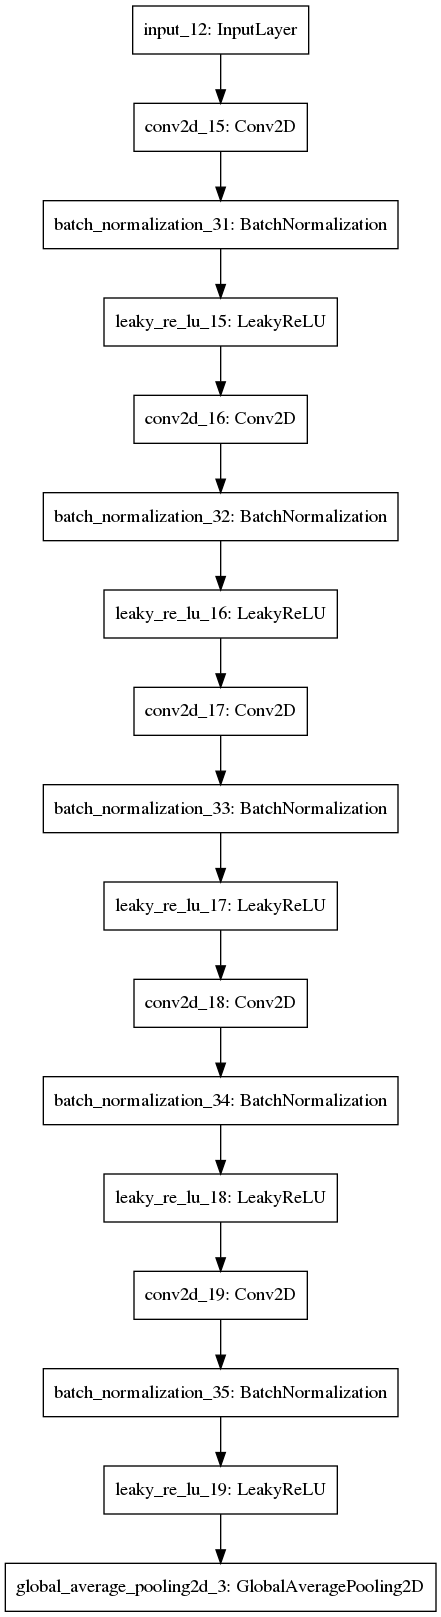

In [83]:
plot_model(encoder, to_file='encoder.png')

In [84]:
# Decoder

z_c = Input(shape=(1,))
z_in = Input(shape=K.int_shape(x)[1:])
pre_out = concatenate([z_in,z_c])

z = pre_out
z = Dense(np.prod(map_size)*z_dim)(z)
z = Reshape(map_size + (z_dim,))(z)
z = Conv2DTranspose(z_dim/2, kernel_size=(5,5), strides=(2,2), padding='SAME')(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Conv2DTranspose(z_dim/4, kernel_size=(5,5), strides=(2,2), padding='SAME')(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Conv2DTranspose(z_dim/8, kernel_size=(5,5), strides=(2,2), padding='SAME')(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Conv2DTranspose(z_dim/16, kernel_size=(5,5), strides=(2,2), padding='SAME')(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Conv2DTranspose(3, kernel_size=(5,5), strides=(2,2), padding='SAME')(z)
z = Activation('tanh')(z)

decoder = Model([z_in,z_c], z)
decoder.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 513)          0           input_14[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2048)         1052672     concatenate_4[0][0]       

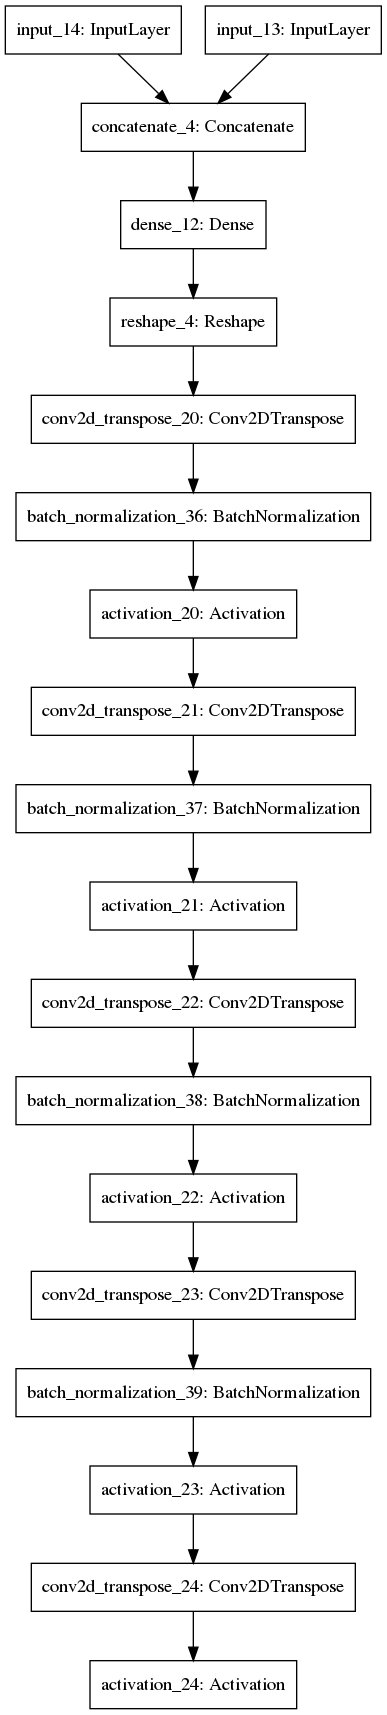

In [85]:
plot_model(decoder, to_file='decoder.png')

In [86]:
class ScaleShift(Layer):
    def __init__(self, **kwargs):
        super(ScaleShift, self).__init__(**kwargs)
    def call(self, inputs):
        z, shift, log_scale = inputs
        z = K.exp(log_scale) * z + shift
        logdet = -K.sum(K.mean(log_scale, 0))
        self.add_loss(logdet)
        return z

In [87]:
z_shift = Dense(z_dim)(x)
z_log_scale = Dense(z_dim)(x)
u = Lambda(lambda z: K.random_normal(shape=K.shape(z)))(z_shift)
z = ScaleShift()([u, z_shift, z_log_scale])

x_recon = decoder([z,z_c])
x_out = Subtract()([x_image, x_recon])

#LOSS FUNCTION NEEDS TO BE CHANGED
recon_loss = 0.5 * K.sum(K.mean(x_out**2, 0)) + 0.5 * np.log(2*np.pi) * np.prod(K.int_shape(x_out)[1:])
z_loss = 0.5 * K.sum(K.mean(z**2, 0)) - 0.5 * K.sum(K.mean(u**2, 0))
vae_loss = recon_loss + z_loss

vae = Model([x_image,z_c], x_out)
plot_model(vae, to_file='vae.png')

vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(1e-4))



In [147]:
print(np.shape(np.ones((1,1))-3.5))
def sample(path):
    n = 2
    figure = np.zeros((img_dim*n, img_dim*n, 3))
    for i in range(n):
        for j in range(n):
            x_recon = decoder.predict([np.random.randn(1, *K.int_shape(x)[1:]),np.ones((1,1))+1])
            digit = x_recon[0]
            figure[i*img_dim: (i+1)*img_dim,
                   j*img_dim: (j+1)*img_dim] = digit
    figure = (figure + 1) / 2 * 255
    figure = figure.astype(np.uint8)
    imageio.imwrite(path, figure)

(1, 1)


In [148]:
class Evaluate(Callback):
    def __init__(self):
        import os
        self.lowest = 1e10
        self.losses = []
        if not os.path.exists('VAE_samples'):
            os.mkdir('VAE_samples')
        with open('VAE_samples/architecture.json', 'w') as f:
            f.write(decoder.to_json())
    def on_epoch_end(self, epoch, logs=None):
        path = 'VAE_samples/test_%s.png' % epoch
        sample(path)
        self.losses.append((epoch, logs['loss']))
        if logs['loss'] <= self.lowest:
            self.lowest = logs['loss']
            decoder.save_weights('VAE_samples/best_encoder.weights')

In [149]:
evaluator = Evaluate()

vae.fit_generator(data_generator(),
                  epochs=total_epoch,
                  steps_per_epoch=int(len(imgs)/batch_size),
                  callbacks=[evaluator]
                 )

Epoch 1/256
63/63 [==============================] - 34s 544ms/step - loss: 11675.8633
Epoch 2/256
63/63 [==============================] - 35s 560ms/step - loss: 11674.7725
Epoch 3/256
63/63 [==============================] - 36s 572ms/step - loss: 11674.0703
Epoch 4/256
63/63 [==============================] - 36s 568ms/step - loss: 11674.3359
Epoch 5/256
63/63 [==============================] - 36s 569ms/step - loss: 11672.6758
Epoch 6/256
63/63 [==============================] - 36s 571ms/step - loss: 11674.5977
Epoch 7/256
63/63 [==============================] - 36s 570ms/step - loss: 11673.3955
Epoch 8/256
63/63 [==============================] - 36s 569ms/step - loss: 11672.3379
Epoch 9/256
63/63 [==============================] - 36s 572ms/step - loss: 11672.7197
Epoch 10/256
63/63 [==============================] - 36s 569ms/step - loss: 11669.6436
Epoch 11/256
63/63 [==============================] - 36s 569ms/step - loss: 11671.1270
Epoch 12/256
63/63 [=====================

63/63 [==============================] - 42s 673ms/step - loss: 11636.4541
Epoch 95/256
63/63 [==============================] - 42s 674ms/step - loss: 11637.5039
Epoch 96/256
63/63 [==============================] - 42s 674ms/step - loss: 11636.1211
Epoch 97/256
63/63 [==============================] - 42s 659ms/step - loss: 11635.3584
Epoch 98/256
63/63 [==============================] - 42s 665ms/step - loss: 11633.7266
Epoch 99/256
63/63 [==============================] - 39s 611ms/step - loss: 11633.4678
Epoch 100/256
63/63 [==============================] - 42s 660ms/step - loss: 11632.5186
Epoch 101/256
63/63 [==============================] - 42s 665ms/step - loss: 11631.0049
Epoch 102/256
63/63 [==============================] - 45s 711ms/step - loss: 11635.9854
Epoch 103/256
63/63 [==============================] - 44s 693ms/step - loss: 11632.0215
Epoch 104/256
63/63 [==============================] - 44s 691ms/step - loss: 11631.7920
Epoch 105/256
63/63 [===================

63/63 [==============================] - 36s 572ms/step - loss: 11611.5928
Epoch 187/256
63/63 [==============================] - 36s 574ms/step - loss: 11609.5625
Epoch 188/256
63/63 [==============================] - 36s 571ms/step - loss: 11610.9307
Epoch 189/256
63/63 [==============================] - 36s 569ms/step - loss: 11610.6680
Epoch 190/256
63/63 [==============================] - 36s 574ms/step - loss: 11613.7666
Epoch 191/256
63/63 [==============================] - 36s 572ms/step - loss: 11608.8916
Epoch 192/256
63/63 [==============================] - 36s 570ms/step - loss: 11608.7910
Epoch 193/256
63/63 [==============================] - 36s 572ms/step - loss: 11611.0986
Epoch 194/256
63/63 [==============================] - 36s 571ms/step - loss: 11608.8105
Epoch 195/256
63/63 [==============================] - 36s 569ms/step - loss: 11609.0332
Epoch 196/256
63/63 [==============================] - 36s 568ms/step - loss: 11608.9033
Epoch 197/256
63/63 [==============